In [1]:
# TensorFlow and tf.keras
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
import glob
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

import cv2 as cv
import argparse
import easydict
import time

Using TensorFlow backend.


In [2]:
allpersons = ["hakkani","mosarrof","tomo","maruf","nobo","arjun","nogami","arif","saidur"]

In [3]:
imagep = glob.glob("./images/*.jpg");
darray = [[0,""]];
for i in imagep:
    for j in allpersons:
        if i.find(j) != -1:
            darray = np.append(darray,[[j,i]], axis=0)

darray = np.delete(darray, 0, 0)

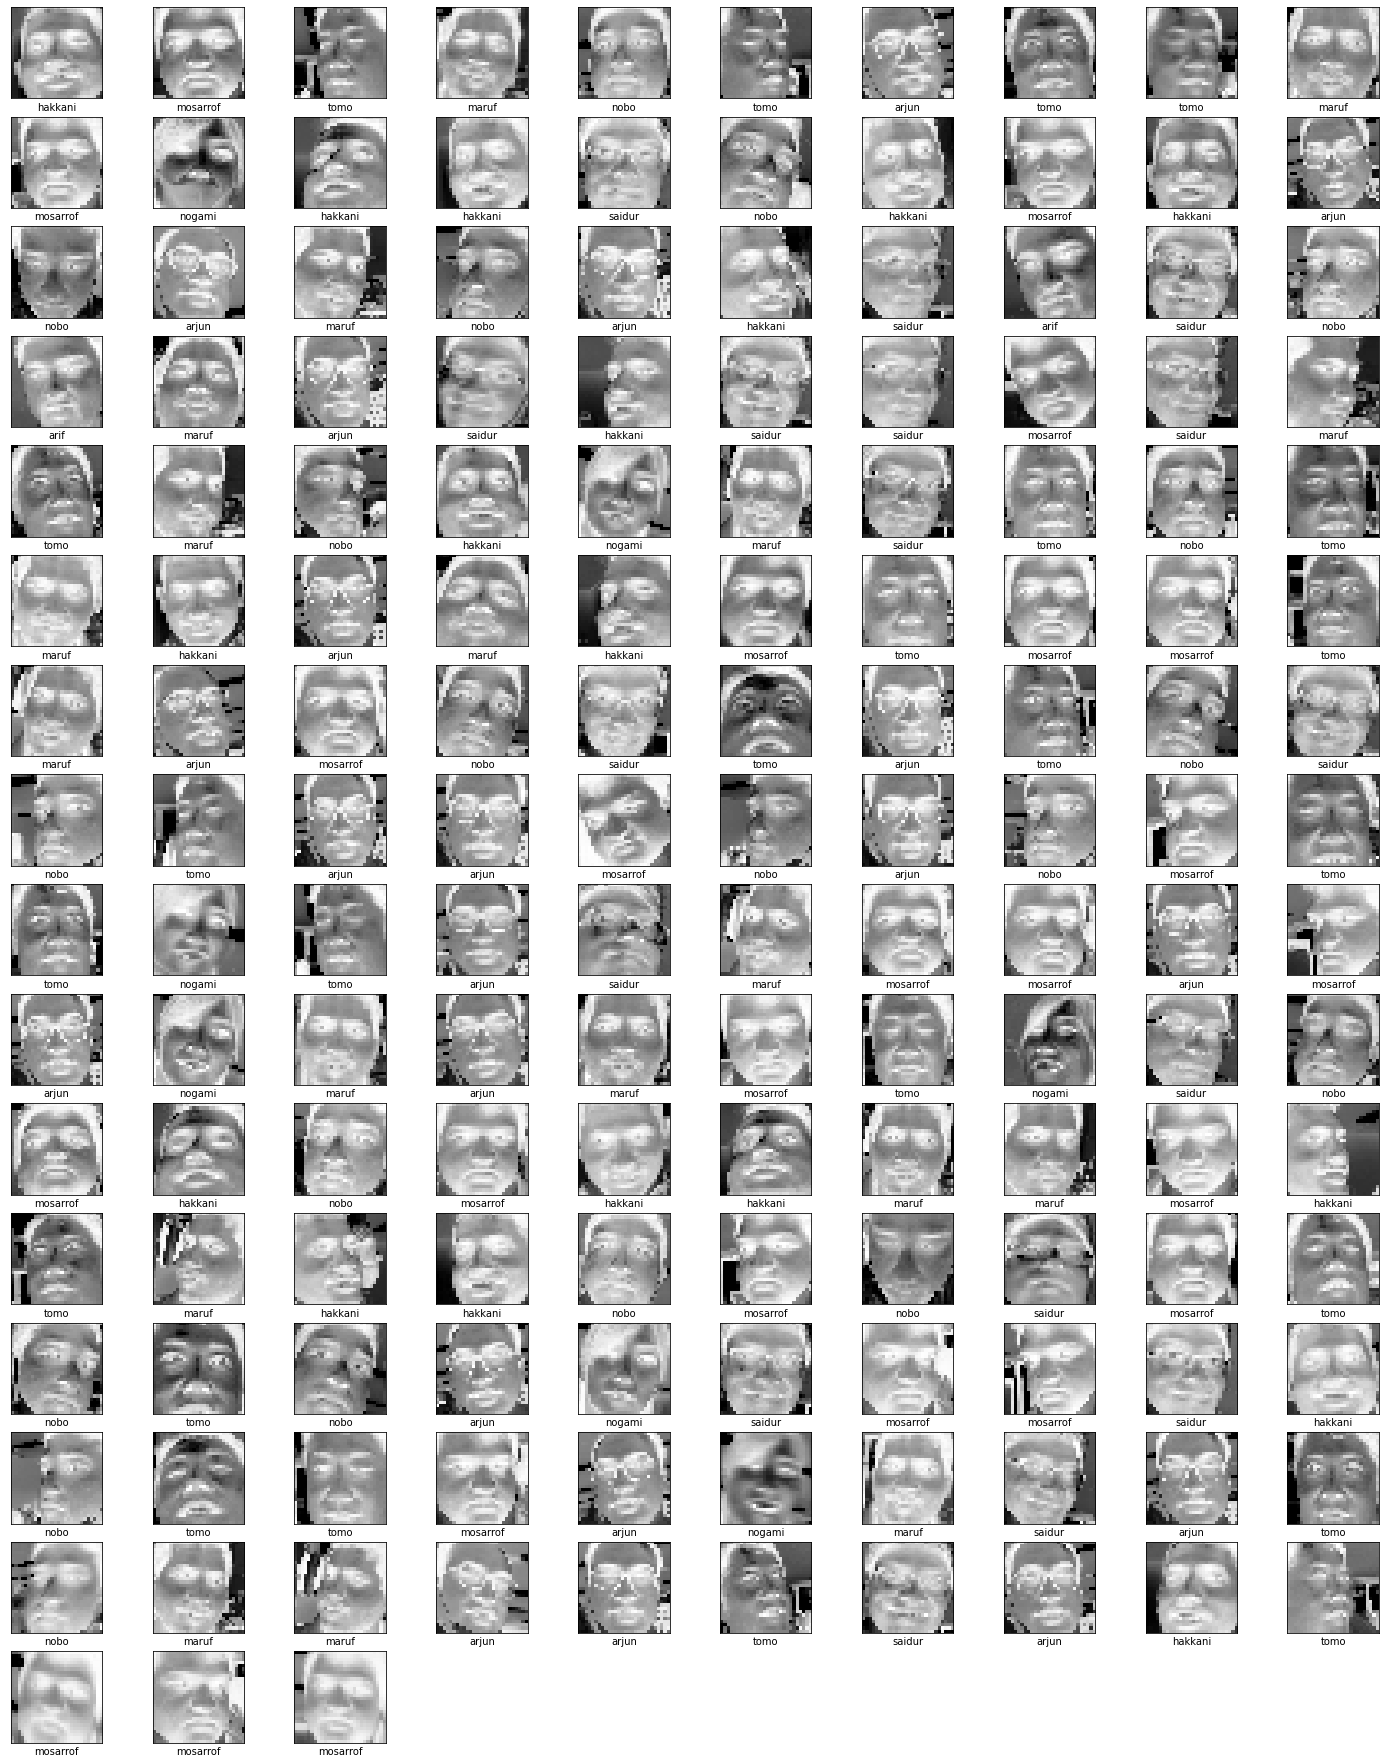

In [4]:
plt.figure(figsize=(25,40))
i=0
collected_image_data = []
train_lebel = []
for f in darray:
    #print(f[1])
    img = load_img(f[1], grayscale=False, color_mode='rgb', target_size=(28,28))
    # convert to numpy array
    img_array = img_to_array(img)

    img_array1 = img_array[:,:,1]
    img_array1 = img_array1/255
    collected_image_data.append(img_array1)
    plt.subplot(20,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_array1, cmap=plt.cm.binary)
    plt.xlabel(f[0])
    train_lebel.append(allpersons.index(f[0]))
    i+=1
    
train_images = np.array(collected_image_data)
train_lebels = np.array(train_lebel)
plt.show()

In [5]:
#Sequential model preparing
digit_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10)
])

In [6]:
#compiling the model
digit_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [7]:
#training the model with train data
digit_model.fit(train_images, train_lebels, epochs=10)

Epoch 1/10
5/5 [==============================] - 0s 962us/step - loss: 2.2011 - accuracy: 0.1373
Epoch 2/10
5/5 [==============================] - 0s 791us/step - loss: 1.9689 - accuracy: 0.3203
Epoch 3/10
5/5 [==============================] - 0s 1ms/step - loss: 1.7753 - accuracy: 0.5098
Epoch 4/10
5/5 [==============================] - 0s 1ms/step - loss: 1.6113 - accuracy: 0.5686
Epoch 5/10
5/5 [==============================] - 0s 889us/step - loss: 1.4927 - accuracy: 0.6536
Epoch 6/10
5/5 [==============================] - 0s 1ms/step - loss: 1.3330 - accuracy: 0.6863
Epoch 7/10
5/5 [==============================] - 0s 876us/step - loss: 1.2057 - accuracy: 0.7908
Epoch 8/10
5/5 [==============================] - 0s 1ms/step - loss: 1.0761 - accuracy: 0.8366
Epoch 9/10
5/5 [==============================] - 0s 823us/step - loss: 0.9927 - accuracy: 0.8366
Epoch 10/10
5/5 [==============================] - 0s 1ms/step - loss: 0.8893 - accuracy: 0.8627


In [8]:
#probability model prepare from trained digit model 
probability_model = tf.keras.Sequential([digit_model, 
                                         tf.keras.layers.Softmax()])

In [9]:
def detectAndDisplay(frame):
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    frame_gray = cv.equalizeHist(frame_gray)

    #-- Detect faces
    faces = face_cascade.detectMultiScale(frame_gray)
    count = 0
    for (x,y,w,h) in faces:
        crop_img = frame[y:y+h, x:x+w]
        crop_img1 = cv.resize(crop_img, (28, 28))
        img_array1 = crop_img1[:,:,1]
        img_array1 = img_array1/255
        
        img1 = (np.expand_dims(img_array1,0))
        predictions_single = probability_model.predict(img1)
        
        print(allpersons[np.argmax(predictions_single[0])])
        
        print(img_array1.shape)
        plt.figure(figsize=(5,5))
        plt.imshow(img_array1)
        plt.colorbar()
        plt.grid(False)
        plt.show()
        
        print(crop_img1.shape)
        count += 1
        center = (x + w//2, y + h//2)
        frame = cv.ellipse(frame, center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 4)
        frame = cv.rectangle(frame, (x,y), (x+w,y+h), (255, 255, 0), 4)
        
        

        faceROI = frame_gray[y:y+h,x:x+w]
        #-- In each face, detect eyes
        eyes = eyes_cascade.detectMultiScale(faceROI)
        for (x2,y2,w2,h2) in eyes:
            eye_center = (x + x2 + w2//2, y + y2 + h2//2)
            radius = int(round((w2 + h2)*0.25))
            frame = cv.circle(frame, eye_center, radius, (255, 0, 0 ), 4)

    cv.imshow('Capture - Face detection', frame)

In [10]:
args = easydict.EasyDict({
        "face_cascade": 'data/haarcascade_frontalface_alt.xml',
        "eyes_cascade": 'data/haarcascade_eye_tree_eyeglasses.xml',
        "camera": 0
})
face_cascade_name = args.face_cascade
eyes_cascade_name = args.eyes_cascade
face_cascade = cv.CascadeClassifier()
eyes_cascade = cv.CascadeClassifier()

#-- 1. Load the cascades
if not face_cascade.load('/home/ai-lab1/.local/lib/python3.6/site-packages/cv2/'+face_cascade_name):
    print('--(!)Error loading face cascade')
    exit(0)
if not eyes_cascade.load('/home/ai-lab1/.local/lib/python3.6/site-packages/cv2/'+eyes_cascade_name):
    print('--(!)Error loading eyes cascade')
    exit(0)
    
camera_device = args.camera
#-- 2. Read the video stream
cap = cv.VideoCapture(camera_device)

if not cap.isOpened:
    print('--(!)Error opening video capture')
    exit(0)
    

In [11]:
while True:
    ret, frame = cap.read()
    if frame is None:
        print('--(!) No captured frame -- Break!')
        break

    detectAndDisplay(frame)   
    if cv.waitKey(10) == 27:
        break